In [13]:
from __future__ import division

"""
Double Dueling DQN: Gridworld
http://localhost:8888/notebooks/Desktop/%EA%B0%95%EC%9D%98%EA%B4%80%EB%A0%A8/Chap6.Double-Dueling-DQN.ipynb
강화학습 첫걸음
"""
"""
에이전트는 파란색 사각형을 위, 아래, 왼쪽, 오른쪽으로 이동시킨다. 
목표는 빨간색 사각형 (-1의 보상)을 피하여 녹색 사각형 (+1의 보상)까지 도달하는 것이다. 
세가지 블록의 위치는 매 에피소드마다 랜덤하게 변하게 된다. 
"""



import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

from gridworld import gameEnv

#========= 게임 환경 로딩 =========#
env = gameEnv(partial=False,size=5)

#========= 신경망 구현 =========#
class Qnetwork():
    def __init__(self,h_size):
        #신경망은 게임으로부터 하나의 프레임을 받아 이를 배열로 만든다 (flattening).
        #배열의 크기를 재조절해주고 4개의 컨벌루션 레이어를 거치면서 처리해 준다.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)  #input(84*84*3 배열)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])      #input 데이터 모양을 바꿔줌
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
            # 위 컨볼루션을 통과하면 사이즈는 20*20    shape(20,20,32)
        
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
               #  shape(9,9,64)
        
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
              #shape(7,7,64)
        
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
                # shape(1,1,h_size)->   h_size=512 
        
        
        #마지막 컨벌루션 레이어로부터의 출력값을 취한 후, 이를 어드밴티지 스트림과 값 스트림으로 분리한다. 
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)   #컬러를 나타내는 3을 기준으로 현재V ,A 두개로 나눠줌
        self.streamA = slim.flatten(self.streamAC)                                     #streamA 와 streamV는 256 차원
        self.streamV = slim.flatten(self.streamVC)
       
    #h_size/2 (256개)개 노드로 정규분포를 이용하여 AW, VW 가중치를 만듬
        self.AW = tf.Variable(tf.random_normal([h_size//2,env.actions]))  #env.actions의 초기값4을 표준편차로 해서 만듬
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))               # 1을 표준 편차로 해서 만듬
        
        #만들어진 AW와 conv4를 반으로 나눈 streamA 곱함(상수화 함)
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #최종 Q-값을 얻기 위해 어드밴티지 스트림과 값 스트림을 조합
        #Advantage에서 Advantage의 평균을 뺀값+Value 값을 더해줌(가장 큰 Qout 값을 추출 )
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        
        # 이것으로 행동을 고름
        self.predict = tf.argmax(self.Qout,1)               
        
        #타겟 Q 값과 예측 Q 값 간의 제곱합 차를 취함으로써 비용을 구한다.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        
        #상하좌우 방향을 원핫인코딩 해줌 4개로 
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        #신경망에서 예상한 Qout 과 행동의 곱을 열기준으로 합하여 Q에 할당
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        #타겟 Q와 현재 Q의 차이를 제곱 으로 에러 구함
        # 그에러를 평균으로 loss 을 구함
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        
        # 아담을 이용하여  손실을 최저로 하는 쪽으로 으로 학습  
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)
        
#========= 경험 재생 =========#
#다음 클래스는 경험과 샘플을 저장하고 랜덤하게 신경망을 학습시킨다 
        
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []                        # 버퍼 초기화, 버퍼사이즈 5만을 할당
        self.buffer_size = buffer_size
    
    #에피소드를 더할때 더할때 버퍼사이즈를 넘으면 앞에서부터 지우고 다시 넣는다
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
    
    #버퍼에서 랜덤으로 32 개의 값을 얻음 -> [32,5]로 만듬   (상태, 행동, 보상, 현재상태, 터미널)
    def sample(self,size):
        
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])        

#게임의 프레임의 사이즈를 조절해줌    21168=[84*84*3] 배열
def processState(states):
    return np.reshape(states,[21168])

#아래 함수들은 1차 신경망의 파라미터와 함께 목표 신경망의 파라미터를 업데이트하게 해준다
#학습 가능한 변수tfVars 와 매인 신경망에서 
# target신경망을 업데이트할때 사용되는 비율 tau를 파라미터로 받음 
def updateTargetGraph(tfVars,tau):
    #tfVars의 절반의 앞은 main 신경망의 값, 나머지는 타겟 신경망 값   총 512개
    total_vars = len(tfVars)
    op_holder = []
    
    #여기서 앞의 절반에 tau를 곱했기 때문에 main 신경망의 가중치에 tau가 
    #곱해지고,      
    #나머지에 1-tau를 곱했기 때문에 타겟 신경망의 가중치에 1-tau가 곱해짐
    #tau가 0.001 이기 때문에 99.999%로 타겟 신경망값이 유지 
    #0.001% 로 main 신경망 값이 더해짐
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

# 타겟 신경망이 업데이트 
def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

#========= 신경망 학습 =========#

#모든 학습 파라미터를 설정한다            
batch_size = 32 #각 학습 단계에서 사용할 경험의 수
update_freq = 4 #학습 단계 기준의 업데이트 주기 
y = .99 #타겟 Q-값에 대한 할인 계수
startE = 1 #시작 시 랜덤 액션의 가능성
endE = 0.1 #종료 시 랜덤 액션의 가능성
anneling_steps = 10000. #startE에서 endE로 줄어드는데 필요한 학습 단계 수
num_episodes = 10000 #신경망을 학습시키기 위한 게임 환경 에피소드의 수
pre_train_steps = 10000 #학습 시작 전 랜덤 액션의 단계 수
max_epLength = 50 #허용되는 최대 에피소드 길이
load_model = False #저장된 모델을 로딩할 지 여부
path = "./dqn" #모델을 저장할 경로
h_size = 512 #어드밴티지 스트림과 값 스트림으로 분리되기 전의 마지막 컨벌루션 레이어의 크기
tau = 0.001 #타겟 신경망를  매인 신경망로 업데이트시켜 가는 비율


# 그래프를 초기화한다
tf.reset_default_graph()
# Q 신경망 클래스를 통해 매인 신경망과 타겟 신경망 을 만든다
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

# 변수들을 초기화한다
init = tf.global_variables_initializer()

# saver를 만든다
saver = tf.train.Saver()

# 학습가능한 변수를 꺼낸다
trainables = tf.trainable_variables()

# 타겟 신경망을 업데이트하기 위한 값을 만든다
targetOps = updateTargetGraph(trainables,tau)

# 경험 즉 에피소드를  저장할 장소
myBuffer = experience_buffer()

#랜덤 액션이 감소하는 비율을 설정 (무작위 행위 확률을 설정)
e = startE
stepDrop = (startE - endE)/anneling_steps         #(1- 0.1/ 10000)

#전체 보상과 에피소드 별 단계 수를 저장할 리스트를 생성, 총 스텝수 초기화 
jList = []
rList = []
total_steps = 0

#모델이 저장될 경로 생성
if not os.path.exists(path):
    os.makedirs(path)

# 텐서플로 세션을 연다
with tf.Session() as sess:
   #변수 초기화
    sess.run(init)
     # 모델을 불러올지 체크
    if load_model == True:
        print('Loading Model...')
        
        #모델을 불러옴
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    
    # 주요 신경망과 동일하게 타겟 신경망을 설정
    updateTarget(targetOps,sess) 
    
     # 에피소드 반복 시작 (학습)
    for i in range(num_episodes):
        
        # 에피소드별 경험 버퍼를 초기화
        episodeBuffer = experience_buffer()
        
        # 환경과 처음 상태을 초기화한다
        s = env.reset()
        s = processState(s)
        
        # 종료 여부
        d = False
        
        # 보상
        rAll = 0
        
        # 걸음
        j = 0
        
        
        #Q-신경망
        # 만약 50 걸음을 초과하면  종료
        while j < max_epLength: 
            j+=1
           
            # 총 스텝수가 학습 시작 전 랜덤 액션의 단계 수10000 보다 작거나
            # 랜덤으로 뽑은수가 e 보다 작을 때 랜덤으로 행동
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                # 신경망을 통해 Q 값을 가져옴
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            
             # 주어진 행동을 실행하고 다음 상태, 보상, 종료 여부를 가져옴
            s1,r,d = env.step(a)
            
             # 상태를 다시 21168 차원으로 리사이즈
            s1 = processState(s1)
            
            # 걸음수를 늘림
            total_steps += 1
            
            # 버퍼에 현재 상태, 행동, 보상, 다음 상태, 종료 여부를 저장
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) 
            
            
            # 총스텝이 1만을 넘으면 시작
            if total_steps > pre_train_steps:
                
                 # 무작위 확률 값을 줄임
                if e > endE:
                    e -= stepDrop
                
                # 총 걸음이 업데이트 수로 나누어 떨어지면 시작
                if total_steps % (update_freq) == 0:
                    
                     # 경험으로부터 랜덤한 배치를 뽑음
                    trainBatch = myBuffer.sample(batch_size) 
                    
                   # target Q-value를 업데이트하는 Double-DQN을 수행 
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    
                    # 타겟 신경망에서 Q 값들을 얻음
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    
                    # 종료 여부에 따라 가짜 라벨을 만듬 (비정상 종료는 1 , 정상종료는 0 )
                    end_multiplier = -(trainBatch[:,4] - 1)  
                    
                # 타겟 신경망의 Q 값들 중에 주요 신경망에서 램덤으로 고른 32개의 Q 값들을 가져옴
                    #(이부분이 doubleQ)     
                    doubleQ = Q2[range(batch_size),Q1]
                    
                     # 보상에 대한 더블 Q 값을 더해줌 , y는 할인율           #trainBatch 종료된 터미널 True  end_multiplier는 1 
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #타겟 값을 이용해 신경망 업데이트
                    #행동들에 대해서 targetQ 값과의 차이를 통해 손실을 구하고 업데이트
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    #주요 신경망과 타겟 신경망이 동일하도록 설정
                    updateTarget(targetOps,sess) 
            
            # 총 보상
            rAll += r
            
            #상태를 바꿔줌
            s = s1
            
            # 종료가 되면 멈춤
            if d == True:

                break
        
        # 이 에피소드로부터의 모든 경험을 저장
        myBuffer.add(episodeBuffer.buffer)
        
        # 걸음을 저장
        jList.append(j)
        
        # 보상을 저장
        rList.append(rAll)
        
        #정기적으로 모델 저장
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        
         # 최근 10개 에피소드의 평균 보상값을 나타냄
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    
    # 모델을 저장한다.
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
    
# 성공확률을 표시    
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

#========= 신경망 학습 확인하기 =========#
#시간의 흐름에 따른 평균 보상

rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)

SyntaxError: unexpected character after line continuation character (<ipython-input-13-3d93030949fe>, line 42)

# 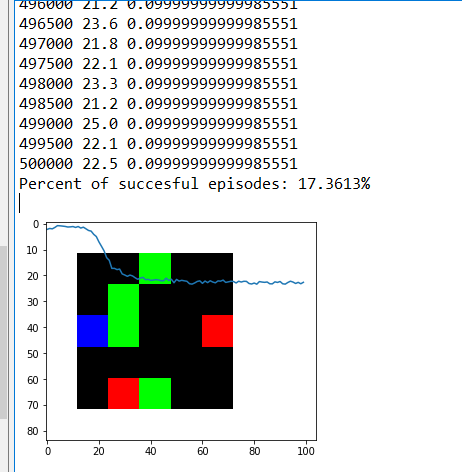

In [ ]:
a= np.